# Выбор оптимального тарифного плана А1 (Беларусь) корпоративной линейки "Своё решение"  
### Февраль 2024 ###

In [189]:
#Ставим таймер автосохранения 
%autosave 30

Autosaving every 30 seconds


<a id='contents'></a>
## Содержание:
1. [Подготовка и предобработка данных](#preprocessing)  
1.1. [Импорт необходимых библиотек](#import)  
1.2. [Формирования датафрейма с действующими тарифами для корпоративных клиентов](#tariff)  
1.3. [Международные звонки](#international_tariff)  
1.3.1 [Пороги выгоды для каждого пакета](#international_tariff_bep)  

2. [Загрузка сырых данных](#raw_processing)  
2.1 [Преобразование типов данных](#precooking)  

3. [Анализ данных](#analyz)  
3.1. [Определение неиспользуемых номеров](#an_unused_numbers)  
3.2. [Определение оптимального тарифа](#an_optimal_tariff)  
3.3. [Определение необходимости подключения пакетов для совершения международных звонков](#an_need_int_package)  
3.4. [Анализ в разрезе одного пользователя](#an_personal)  

4. [Комплексный анализ поведения пользователей](#an_complex)

<a id='preprocessing'></a>
## Подготовка и предобработка данных

[Назад к содержанию](#contents)

<a id='import'></a>
### Импорт необходимых библиотек
[Назад к содержанию](#contents)

**os**: *Эта библиотека используется для взаимодействия с операционной системой. С её помощью можно выполнять операции, связанные с файловой системой, например, получение пути к файлам, перечисление файлов в директории и т.д.*

**pandas**: *Одна из основных библиотек для анализа данных в Python. Предоставляет структуры данных DataFrame и Series для манипуляции с табличными данными, удобное чтение и запись данных из/в различные форматы (CSV, Excel и т.д.), а также множество функций для обработки и анализа данных.*

**numpy**: *Библиотека для эффективных вычислений с массивами и матрицами в Python. Используется в качестве основы для многих других библиотек анализа данных и научных вычислений.*

**matplotlib.pyplot**: *Модуль библиотеки Matplotlib, предназначен для создания статических, интерактивных и анимированных визуализаций в Python. plt является традиционным псевдонимом для обращения к функциям этого модуля.*

**seaborn**: *Библиотека визуализации данных на основе matplotlib, предоставляющая более высокоуровневый интерфейс для создания статистических графиков. Улучшает внешний вид графиков и дополняет matplotlib дополнительными типами графиков.*

**glob**: *Библиотека для создания списков файлов из директорий с использованием шаблонов. Позволяет выполнять поиск файлов по заданным шаблонам (например, все файлы Excel в директории).*

**openpyxl**: *Библиотека для чтения и записи файлов Excel (xlsx/xlsm/xltx/xltm). Позволяет работать с электронными таблицами Excel, изменять данные, форматы, формулы и т.д.*

**sklearn.preprocessing.StandardScaler**: *Компонент библиотеки scikit-learn, используемый для стандартизации признаков путём удаления среднего и масштабирования до единичной дисперсии. Это часто необходимо перед применением многих алгоритмов машинного обучения.*

**sklearn.cluster.KMeans**: *Модуль библиотеки scikit-learn для кластеризации данных методом K-средних. Используется для разделения данных на предварительно определенное количество кластеров.*

**warnings**: *Библиотека для управления предупреждениями в Python. Позволяет игнорировать определенные предупреждения, что может быть полезно для подавления несущественных сообщений, которые не влияют на выполнение программы.*

In [190]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import openpyxl

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Устанавливаем стиль визуализации по умолчанию для seaborn
sns.set()

import warnings

# Игнорирование конкретного предупреждения из библиотеки openpyxl
warnings.filterwarnings("ignore", message="Workbook contains no default style, apply openpyxl's default")

<a id='tariff'></a>
### Формирования датафрейма с действующими тарифами для корпоративных клиентов
[Назад к содержанию](#contents)

Формирования данных о действующих тарифах для корпоративных клиентов компании А1 и их сверхлимитных ставках. 

Создается словарь `tariffs_options`, где каждому тарифу (Лидер, Эксперт, Мастер, Новатор, и специальный тариф Передача данных) соответствует список опций. Каждая опция описывает условия тарифа: количество минут (minutes), объем интернет-трафика в гигабайтах (gb) и цену в долларах (price). Эти данные предназначены для анализа доступных тарифных планов и их условий для корпоративных клиентов.

In [191]:
# Действующие тарифы А1 "Своё решение" для корпоративных клиентов
tariffs_options = {
    'Лидер': [
        {'minutes': 'unlimited', 'gb': 30, 'price': 33.81},
        {'minutes': 1200, 'gb': 40, 'price': 33.81},
        {'minutes': 1000, 'gb': 50, 'price': 33.81},
        {'minutes': 800, 'gb': 'unlimited', 'price': 33.81},
    ],
    'Эксперт': [
        {'minutes': 'unlimited', 'gb': 20, 'price': 27.37},
        {'minutes': 800, 'gb': 30, 'price': 27.37},
        {'minutes': 600, 'gb': 40, 'price': 27.37},
        {'minutes': 400, 'gb': 'unlimited', 'price': 27.37},
    ],
    'Мастер': [
        {'minutes': 'unlimited', 'gb': 0, 'price': 19.93},
        {'minutes': 500, 'gb': 5, 'price': 19.93},
        {'minutes': 300, 'gb': 15, 'price': 19.93},
        {'minutes': 100, 'gb': 25, 'price': 19.93},
    ],
    'Новатор': [
        {'minutes': 200, 'gb': 0, 'price': 10.50},
        {'minutes': 100, 'gb': 5, 'price': 10.50},
        {'minutes': 0, 'gb': 10, 'price': 10.50},
    ],
    'Передача данных': [
        {'minutes': 0, 'gb': 0, 'price': 2.06}  # Специальный тариф
    ]
}

Создание датафрейма для сверхлимитных ставок:

В словаре `overlimit_rates` хранится информация о сверхлимитных ставках для различных услуг (Интернет-трафик, Исходящие внутри сети и на голосовую почту, SMS исходящие международные) по каждому тарифу (Лидер, Эксперт, Мастер, Новатор). Этот словарь содержит три ключа: Тариф, Услуга и Цена за единицу, где указаны названия тарифов, типы услуг и цены за единицу сверх установленных лимитов.

Далее, словарь `overlimit_rates` преобразуется в объект DataFrame с помощью функции pd.DataFrame(). Полученный датафрейм `overlimit_df` организует данные в табличной форме, что упрощает анализ сверхлимитных ставок по различным услугам для каждого тарифа.

In [192]:
# Создание DataFrame для хранения информации о сверхлимитных ставках для каждого тарифа
overlimit_rates = {
    "Тариф": ["Лидер", "Эксперт", "Мастер", "Новатор"] * 3,
    "Услуга": ["Интернет-трафик", "Исходящие внутри сети и на голосовую почту", "SMS исходящие международные"] * 4,
    "Цена за единицу": [
        # Лидер, Эксперт, Мастер, Новатор
        0.0596, 0.06, 0.185, 0.0596, 0.06, 0.185, 0.0596, 0.06, 0.185, 0.0596, 0.06, 0.185,
    ]
}

# Преобразование словаря в DataFrame
overlimit_df = pd.DataFrame(overlimit_rates)

<a id='international_tariff'></a>
### Международные звонки
[Назад к содержанию](#contents)

Определение стоимости международных звонков по регионам:

Словарь `international_call_rates` хранит информацию о стоимости минуты международного звонка для различных регионов: СНГ, Европа и Другие страны. Значения указаны в за минуту.
Описание пакетов международных звонков:

Список `international_calls_packages` содержит словари, каждый из которых описывает определенный пакет международных звонков. Для каждого пакета указано название (`name`), количество минут (`minutes`), регионы, в которых действует пакет (`regions`), и цена пакета (`price`).

Для каждого пакета рассчитывается и добавляется стоимость одной минуты разговора (`cost_per_minute`), которая получается делением общей цены пакета на количество минут. Это позволяет оценить, насколько выгодно использование каждого пакета с точки зрения стоимости одной минуты звонка.
Расчет пороговых значений для каждого пакета:

Для каждого пакета рассчитываются пороговые значения (`break_even_points`), которые показывают, сколько минут необходимо использовать по данному пакету в каждом регионе, чтобы пакет стал выгоднее оплаты звонков по стандартной ставке (рассчитанной из `international_call_rates`).

Если пакет действует во всех странах, пороговые значения рассчитываются для каждого региона. Если пакет ограничен определенными регионами, расчет проводится только для этих регионов.

In [193]:
# Стоимость международных звонков за минуту в зависимости от региона
international_call_rates = {
    'СНГ': 0.805,
    'Европа': 1.15,
    'Другие страны': 2.30,
}

# Пакеты международных звонков
international_calls_packages = [
    {'name': 'Международный 100', 'minutes': 100, 'regions': ['СНГ', 'Европа'], 'price': 55.83},
    {'name': '20 минут международных звонков', 'minutes': 20, 'regions': ['Все страны'], 'price': 13.50},
    {'name': '50 минут международных звонков', 'minutes': 50, 'regions': ['Все страны'], 'price': 30.50},
    {'name': 'Международный 250', 'minutes': 250, 'regions': ['СНГ', 'Европа'], 'price': 133.57},
]

# Добавление стоимости минуты внутри пакета
for package in international_calls_packages:
    package['cost_per_minute'] = package['price'] / package['minutes']

# Расчет порогового значения для каждого пакета
for package in international_calls_packages:
    # Проверяем, действует ли пакет во всех странах
    if 'Все страны' in package['regions']:
        # Рассчитываем порог для каждого региона из international_call_rates
        package['break_even_points'] = [(region, package['price'] / rate) for region, rate in international_call_rates.items()]
    else:
        # Рассчитываем порог только для указанных в пакете регионов
        package['break_even_points'] = [(region, package['price'] / international_call_rates[region]) for region in package['regions']]

<a id='international_tariff_bep'></a>
#### Пороги выгоды для каждого пакета

In [194]:
# Вывод результатов
for package in international_calls_packages:
    print(f"Пакет: {package['name']}")
    for region, break_even in package['break_even_points']:
        print(f"  Регион: {region}, Порог: {break_even:.2f} минут")
    print("-------")

Пакет: Международный 100
  Регион: СНГ, Порог: 69.35 минут
  Регион: Европа, Порог: 48.55 минут
-------
Пакет: 20 минут международных звонков
  Регион: СНГ, Порог: 16.77 минут
  Регион: Европа, Порог: 11.74 минут
  Регион: Другие страны, Порог: 5.87 минут
-------
Пакет: 50 минут международных звонков
  Регион: СНГ, Порог: 37.89 минут
  Регион: Европа, Порог: 26.52 минут
  Регион: Другие страны, Порог: 13.26 минут
-------
Пакет: Международный 250
  Регион: СНГ, Порог: 165.93 минут
  Регион: Европа, Порог: 116.15 минут
-------


<a id='raw_processing'></a>
## Загрузка сырых данных

[Назад к содержанию](#contents)

---

*Используем детализации, доступные в `Личном Кабинете` > `Раздел "Финансы"` > `"Детализация на Email"` в разрезе номеров и месяцев*

---

Установка пути к файлам с сырыми данными:

Переменная `raw_data_path` содержит путь к файлам Excel, которые нужно обработать. В примере используется шаблон `./a1_office/*.xlsx`, что означает, что будут выбраны все файлы с расширением `.xlsx` в папке `a1_office`.
Подготовка списка для хранения данных:

Создается пустой DataFrame `raw_data`, в который будут собираться данные из всех обрабатываемых файлов.
Загрузка и обработка файлов Excel:

С помощью функции `glob.glob(raw_data_path)` получаем список всех файлов, соответствующих указанному шаблону пути.

Для каждого файла в списке files выполняем следующие действия:

Загружаем данные из файла в DataFrame df с помощью функции `pd.read_excel(file)`.
Добавляем в df столбец Номер телефона, значение которого формируется из имени файла. Для этого извлекаем имя файла с помощью `os.path.basename(file)`, разделяем его по пробелу и берем первую часть, предполагая, что это номер телефона.
С помощью функции `pd.concat([raw_data, df], ignore_index=True) `объединяем текущий DataFrame df с уже существующими данными в `raw_data`, обеспечивая непрерывную нумерацию индексов (благодаря параметру `ignore_index=True`).

In [195]:
# Установите путь к вашим файлам с сырыми данными
raw_data_path = './RAW/*.xlsx'  # Убедитесь, что путь указан корректно
files = glob.glob(raw_data_path)

# Список для хранения всех датафреймов с сырыми данными
raw_data = pd.DataFrame()

# Загрузка всех файлов Excel из директории
for file in files:
    df = pd.read_excel(file)
    # Добавление столбца с идентификатором файла, извлекаемым из имени файла
    df['Номер телефона'] = os.path.basename(file).split(' ')[0]
    raw_data = pd.concat([raw_data, df], ignore_index=True)  # Исправляем на правильное имя переменной

<a id='precooking'></a>
## Преобразование типов данных

[Назад к содержанию](#contents)

Преобразовываем и очищаем данные, чтобы подготовить их к дальнейшему анализу и обработке. Работа ведется в несколько этапов, каждый из которых направлен на улучшение качества данных и их структуры для обеспечения более эффективного и точного анализа.

1. Преобразование дат и времени:  

`Дата звонка`: Преобразуем строковое представление даты звонка в формат `datetime`, что позволяет использовать мощные инструменты pandas для работы с временными рядами.  

2. Преобразование числовых данных:  

`Номер телефона`, Кто звонил: Преобразуем эти столбцы в числовой формат `int64` для обеспечения единообразия данных и возможности выполнения математических операций.  

3. Преобразование продолжительности звонков:  

`Длительность, сек.`: Конвертируем длительность звонков из формата `HH:MM:SS` в секунды для унификации и упрощения анализа.  

In [196]:
# Преобразование 'Дата звонка' в datetime
raw_data['Дата звонка'] = pd.to_datetime(raw_data['Дата звонка'])

# Преобразование 'Номер телефона', 'Кто звонил', и 'Куда звонил' в int
raw_data['Номер телефона'] = raw_data['Номер телефона'].astype('int64')
raw_data['Кто звонил'] = raw_data['Кто звонил'].astype('int64')

# Преобразование 'Длительность, сек.' из формата HH:MM:SS в секунды
def process_duration(row):
    if 'SMS' in row['Тип звонка'] or not isinstance(row['Длительность, сек.'], str):
        # Если тип звонка - SMS, или если 'Длительность, сек.' не является строкой, возвращаем значение как есть.
        # Это предполагает, что для SMS или некоторых других случаев длительность звонка может быть уже в секундах или не применима.
        return row['Длительность, сек.']
    else:
        # В противном случае пытаемся преобразовать HH:MM:SS длительность в секунды.
        try:
            h, m, s = row['Длительность, сек.'].split(':')
            return int(h) * 3600 + int(m) * 60 + int(s)
        except ValueError:
            # Если встречается ошибка (например, из-за неправильного формата), возвращаем 0 или другое логичное значение по умолчанию.
            return 0

# Применение исправленной функции к датафрейму
raw_data['Длительность, сек.'] = raw_data.apply(process_duration, axis=1)

4. Работа с информацией о пользователях:  
  
Загрузка и преобразование данных о пользователях: Загружаем данные о пользователях и их тарифах, преобразуем номера телефонов для соответствия с основным датафреймом, а также конвертируем другие релевантные поля. 

*Загрузка справочника абонентов*

Получить можно в ЛК > Раздел "Абоненты" > Выгрузить в Excel

In [197]:
# Загрузка информации о пользователях и их текущих тарифах
accounts_df = pd.read_excel('accounts.xlsx')

# Преобразование 'Номер/Логин' к строковому типу и очистка от пробелов
accounts_df['Номер/Логин'] = accounts_df['Номер/Логин'].astype(str).str.strip()

# Преобразование 'SIM/Точка подключения' в int (если это возможно)
# Обратите внимание: если в этом столбце есть нечисловые значения, преобразование вызовет ошибку
accounts_df['SIM/Точка подключения'] = pd.to_numeric(accounts_df['SIM/Точка подключения'], errors='coerce')

# Заполнение NaN значений, если они есть, после попытки конвертации
accounts_df['SIM/Точка подключения'] = accounts_df['SIM/Точка подключения'].fillna(0).astype(int)

# Преобразование DataFrame в словарь
accounts_info = accounts_df.set_index('Номер/Логин').to_dict('index')


5. Объединение данных:  

Интеграция данных о пользователях с основным датафреймом: Объединяем информацию о пользователях с основным датафреймом для получения полной картины по каждому звонку, включая тариф и статус пользователя.  
  
6. Добавление и классификация новых атрибутов:  
  
Классификация типов соединений: Добавляем новые столбцы, такие как `Год звонка` и `Месяц звонка`, для удобства агрегации данных по временным периодам. Также классифицируем типы звонков и соединений для упрощения анализа паттернов использования услуг.

In [198]:
# Проверяем, что 'Номер телефона' в raw_data и 'Номер/Логин' в accounts_df имеют одинаковый тип данных
raw_data['Номер телефона'] = raw_data['Номер телефона'].astype(str)

# Объединение основного датафрейма с информацией о пользователях
data = raw_data.merge(accounts_df, how='left', left_on='Номер телефона', right_on='Номер/Логин')

# Переименование столбцов и изменение порядка
data = data.rename(columns={'Имя': 'ФИО', 'Тариф': 'Тариф', 'Статус': 'Статус'})

# Добавление столбца 'Год звонка'
data['Год звонка'] = data['Дата звонка'].dt.year

# Добавление столбца 'Месяц звонка'
data['Месяц звонка'] = data['Дата звонка'].dt.month

data = data[['Номер телефона', 'ФИО', 'Тариф', 'Статус', 'Тип звонка', 'Год звонка', 'Месяц звонка', 'Дата звонка', 'Длительность, сек.', 'Объем, Кбайт', 'Куда звонил', 'Начислено']]

# Удаление одного из дублирующихся столбцов 'ФИО', если они идентичны
data = data.loc[:,~data.columns.duplicated()]

def classify_connection_type(row):
    if 'Интернет-трафик' in row['Тип звонка']:
        return 'Интернет-трафик'
    elif 'SMS входящие' in row['Тип звонка']:
        return 'Входящие SMS'
    elif 'SMS исходящие' in row['Тип звонка'] or 'SMS на сервисные номера компании' in row['Тип звонка']:
        return 'Исходящие SMS'
    elif 'Входящие' in row['Тип звонка']:
        return 'Входящие звонки'
    elif ('Исходящие' in row['Тип звонка'] or 
          'Бесплатные звонки' in row['Тип звонка'] or 
          'Звонки на справочные/ короткие номера' in row['Тип звонка'] or 
          'Международные звонки (СНГ)' in row['Тип звонка']):
        return 'Исходящие звонки'
    elif 'Звонки в ЗАГ' in row['Тип звонка'] or 'Команда' in row['Тип звонка']:
        return 'Звонки в ЗАГ'
    elif 'Переадресация на голосовую почту' in row['Тип звонка']:
        return 'Переадресация на голосовую почту'
    else:
        return 'Другое'

# Применяем обновленную функцию к каждой строке в DataFrame
data['Категория соединения'] = data.apply(classify_connection_type, axis=1)


def define_connection_type(row):
    category = row['Категория соединения'].lower()  # Приведение к нижнему регистру для унификации
    if 'sms' in category:
        return 'SMS'
    elif 'интернет-трафик' == category:
        return 'Трафик'
    elif 'звонки' in category or 'переадресация на голосовую почту' == category:
        return 'Звонки'
    else:
        return 'Другое'

# Применение исправленной функции к каждой строке DataFrame для обновления столбца 'Тип'
data['Тип'] = data.apply(define_connection_type, axis=1)

---

<a id='analyz'></a>
## Анализ данных

[Назад к содержанию](#contents)

<a id='an_unused_numbers'></a>
### Определение неиспользуемых номеров ###
[Назад к содержанию](#contents)

Выявление неиспользуемых номеров телефонов среди аккаунтов. Это позволяет определить, какие номера телефонов зарегистрированы в системе, но не участвовали в звонках или других активностях за рассматриваемый период.

##### Создание списка уникальных номеров телефонов, использованных в данных: #####

Из датафрейма `data`, содержащего информацию о звонках и других активностях, извлекается массив уникальных номеров телефонов (`used_phones`), что позволяет понять, какие номера были активны.

##### Получение списка всех зарегистрированных номеров телефонов: #####

Из датафрейма `accounts_df`, включающего сведения обо всех аккаунтах, извлекается массив всех зарегистрированных номеров телефонов (`all_phones`), что дает полное представление о доступных номерах.

##### Выявление неиспользуемых номеров: #####

Сравнивая массивы `used_phones` и `all_phones`, определяются номера, которые есть в списке всех номеров, но отсутствуют среди используемых (`unused_phones`). Это достигается с помощью функции np.isin, которая проверяет присутствие элементов одного массива в другом, и инвертирования результата для получения номеров, не встречающихся в данных о звонках.

##### Преобразование массива в список для дальнейшей фильтрации: #####

Массив `unused_phones` преобразуется обратно в список (`unused_phones_list`), что облегчает его использование для фильтрации в `pandas`.
##### Фильтрация аккаунтов по неиспользуемым номерам: #####

Проводится фильтрация датафрейма `accounts_df` для выявления записей, соответствующих неиспользуемым номерам. Результатом является датафрейм `unused_phones_with_names`, включающий номера телефонов и имена владельцев, что помогает идентифицировать владельцев неактивных номеров.

In [199]:
# Список уникальных номеров телефонов в data
used_phones = data['Номер телефона'].unique()

# Список всех номеров телефонов в accounts_df
all_phones = accounts_df['Номер/Логин'].unique()

# Находим номера телефонов из accounts_df, которые не используются в data
unused_phones = all_phones[~np.isin(all_phones, used_phones)]

# Преобразование массива unused_phones обратно в список для фильтрации
unused_phones_list = unused_phones.tolist()

# Фильтрация accounts_df для нахождения ФИО по неиспользуемым номерам
unused_phones_with_names = accounts_df[accounts_df['Номер/Логин'].isin(unused_phones_list)][['Номер/Логин', 'Имя']]

In [200]:
# Вывод результатов
unused_phones_with_names

,Номер/Логин,Имя
0,375291000001,Абонент 01
1,375291000002,Абонент 02
3,375291000004,Абонент 04
5,375291000006,Абонент 06


### Сохраняем список в файл ###

In [201]:
# Указываем имя файла для сохранения
excel_filename = "unused_phones_with_names.xlsx"

# Сохранение DataFrame в Excel
unused_phones_with_names.to_excel(excel_filename, index=False)

# Вывод сообщения об успешном сохранении файла
print(f"Файл '{excel_filename}' успешно сохранен.")

Файл 'unused_phones_with_names.xlsx' успешно сохранен.


---

<a id='an_optimal_tariff'></a>
### Определение оптимального тарифа ###
[Назад к содержанию](#contents)

Определение оптимального тарифа для пользователей на основе их паттернов использования услуг. Процесс включает в себя несколько ключевых этапов:

#### Подготовка данных ####   

##### Формирование базового DataFrame: #####  
Создаем датафрейм `user_info`, включающий информацию о пользователях, такую как номер телефона, ФИО и текущий тариф. Это предоставляет основу для расчетов. 

##### Анализ исходящих звонков: #####   
Выбираем данные по исходящим звонкам, исключая международные, и преобразуем длительность звонков в минуты. Далее, рассчитываем среднемесячную длительность исходящих звонков для каждого пользователя.  

##### Анализ использования интернет-трафика: #####  
Аналогично, для интернет-трафика конвертируем объем данных в гигабайты и рассчитываем среднемесячный объем трафика для каждого пользователя.


In [202]:
# Базовый DataFrame для рассчёта Оптимального тарифа
user_info = accounts_df[['Номер/Логин', 'Имя', 'Тариф']].rename(columns={'Номер/Логин': 'Номер телефона', 'Имя': 'ФИО'})

In [203]:
# Создаем копию для исходящих звонков, исключая международные
outgoing_calls = data[(data['Категория соединения'] == 'Исходящие звонки') & 
                      (data['Тип звонка'] != 'Международные звонки (СНГ)')].copy()

# Конвертация длительности звонков из секунд в минуты
outgoing_calls['Длительность, мин'] = outgoing_calls['Длительность, сек.'] / 60

# Группировка по номеру телефона, году и месяцу звонка и расчет суммы длительности звонков за месяц
monthly_outgoing = outgoing_calls.groupby(['Номер телефона', 'Год звонка', 'Месяц звонка'])['Длительность, мин'].sum().reset_index()

# Расчет среднего значения суммарной длительности звонков в месяц для каждого абонента (округляем до 2 знаков после запятой)
average_monthly_outgoing = monthly_outgoing.groupby('Номер телефона')['Длительность, мин'].mean().apply(round, 2).reset_index()
average_monthly_outgoing.rename(columns={'Длительность, мин': 'Исходящие, мин (сред. в месяц)'}, inplace=True)

# Теперь у нас есть DataFrame average_monthly_outgoing с колонками 'Номер телефона' и 'Исходящие, мин (сред. в месяц)'

In [204]:
# Фильтрация данных для получения только интернет-трафика
internet_traffic = data[data['Тип'] == 'Трафик'].copy()

# Конвертация объема данных из Кбайт в ГБ
internet_traffic['Объем, ГБ'] = internet_traffic['Объем, Кбайт'] / (1024**2)

# Группировка по номеру телефона, году и месяцу звонка и расчет суммы трафика за месяц
monthly_traffic = internet_traffic.groupby(['Номер телефона', 'Год звонка', 'Месяц звонка'])['Объем, ГБ'].sum().reset_index()

# Расчет среднего значения объема трафика в месяц для каждого абонента
average_monthly_traffic = monthly_traffic.groupby('Номер телефона')['Объем, ГБ'].mean().reset_index()
average_monthly_traffic.rename(columns={'Объем, ГБ': 'Трафик, ГБ (сред. в месяц)'}, inplace=True)
average_monthly_traffic['Трафик, ГБ (сред. в месяц)'] = np.ceil(average_monthly_traffic['Трафик, ГБ (сред. в месяц)'])

# Теперь у нас есть DataFrame average_monthly_traffic с колонками 'Номер телефона' и 'Трафик, ГБ (сред. в месяц)'

In [205]:
# Добавление информации о среднемесячных исходящих минутах
user_info = user_info.merge(
    average_monthly_outgoing,
    on='Номер телефона',
    how='left'
)

# Добавление информации о среднемесячном трафике в ГБ
user_info = user_info.merge(
    average_monthly_traffic,
    on='Номер телефона',
    how='left'
)

# Замена NaN на 0 для случаев, когда данные отсутствуют
user_info.fillna(0, inplace=True)

#### Расчет оптимального тарифа #### 
###### Объединение данных: ######
Добавляем к `user_info` информацию о среднемесячных исходящих минутах и интернет-трафике.

###### Определение оптимального тарифа: ######
С помощью функции `find_optimal_tariff_and_options` для каждого пользователя определяем наиболее подходящий тариф на основе его среднемесячного использования услуг. Расчет включает сравнение стоимости текущего использования с тарифными опциями, предоставляемыми компанией.

---

#### Описание функций ####
##### Функция format_option ######
Эта функция предназначена для форматирования представления тарифной опции, делая ее более понятной и читаемой. Она принимает словарь `option`, содержащий информацию о количестве минут (minutes) и объеме интернет-трафика (gb), предоставляемых в рамках тарифа.

Если количество минут или объем трафика указаны как 'unlimited', функция возвращает строку 'неограниченно' для соответствующего параметра.
В противном случае она возвращает строковое представление лимитов с указанием единиц измерения (минуты или гигабайты).
Результатом работы функции является строка, описывающая тарифную опцию в формате, удобном для восприятия (например, "1000 мин, 10 Гб").

###### Функция find_optimal_tariff_and_options #####
Эта функция выполняет основную работу по определению оптимального тарифа для конкретного пользователя. Она анализирует использование услуг пользователем и сравнивает его с доступными тарифными опциями для выбора наиболее выгодного варианта.

Специальный случай для тарифа передачи данных: Если текущий тариф пользователя специализирован на передаче данных ('Передача данных'), функция сразу возвращает этот тариф, предполагая, что изменение не требуется.

Расчет для остальных случаев: Для пользователей на других тарифах функция анализирует среднемесячное использование минут и интернет-трафика. Затем она перебирает все доступные тарифы (исключая специализированный тариф для данных) и опции внутри этих тарифов, рассчитывая общую стоимость для пользователя с учетом его потребления.

Определение оптимального варианта: Для каждой тарифной опции функция сравнивает базовую стоимость с дополнительными расходами на сверхлимитное использование услуг. Оптимальным считается тариф с наименьшей общей стоимостью для пользователя.

Форматирование результата: Выбранный тариф и его опция форматируются с помощью функции `format_option`, и результат возвращается в виде кортежа, включающего название тарифа, описание опции и общую стоимость.

Функция `find_optimal_tariff_and_options` позволяет не только идентифицировать наиболее подходящий тарифный план на основе реального использования услуг пользователем, но и представить эту информацию в формате, максимально удобном для понимания и принятия решений.

In [206]:
def format_option(option):
    minutes = 'неограниченно' if option['minutes'] == 'unlimited' else f"{option['minutes']} мин"
    gb = 'неограниченно' if option['gb'] == 'unlimited' else f"{option['gb']} Гб"
    return f"{minutes}, {gb}"

def find_optimal_tariff_and_options(row):
    # Проверяем, не является ли текущий тариф специализированным для передачи данных
    if 'Передача данных' in row['Тариф']:
        # Если это специализированный тариф для передачи данных, возвращаем его стоимость
        data_tariff_cost = tariffs_options['Передача данных'][0]['price']
        return row['Тариф'], "Спец. тариф для данных", data_tariff_cost

    # Если это не специализированный тариф, вычисляем оптимальный тариф
    usage = {'minutes': row['Исходящие, мин (сред. в месяц)'], 'gb': row['Трафик, ГБ (сред. в месяц)']}
    optimal_choice = {'tariff': None, 'option': None, 'total_cost': float('inf')}
    
    # Исключаем из рассмотрения тариф "Передача данных"
    for tariff_name, options in {k: v for k, v in tariffs_options.items() if k != 'Передача данных'}.items():
        for option in options:
            minutes_limit = float('inf') if option['minutes'] == 'unlimited' else option['minutes']
            gb_limit = float('inf') if option['gb'] == 'unlimited' else option['gb']
            extra_minutes_cost = 0 if usage['minutes'] <= minutes_limit else (usage['minutes'] - minutes_limit) * 0.1
            extra_gb_cost = 0 if usage['gb'] <= gb_limit else (usage['gb'] - gb_limit) * 2
            total_cost = option['price'] + extra_minutes_cost + extra_gb_cost
            if total_cost < optimal_choice['total_cost']:
                optimal_choice = {
                    'tariff': tariff_name,
                    'option': format_option(option),
                    'total_cost': total_cost
                }
    return optimal_choice['tariff'], optimal_choice['option'], optimal_choice['total_cost']


# Применение функции к DataFrame и создание новых столбцов
user_info[['Оптимальный тариф', 'Опция внутри тарифа', 'Стоимость тарифа']] = user_info.apply(find_optimal_tariff_and_options, axis=1, result_type='expand')

##### Дополнительная классификация и анализ #####
**Статус активности:** Определяем активность пользователя на основе наличия данных о его звонках и интернет-сессиях, отмечая пользователей как "Активные" или "Неактивные".

**Активность по месяцам:** Рассчитываем количество месяцев активности для каждого пользователя, что может служить дополнительным показателем для определения подходящего тарифа.

In [207]:
# Список всех абонентов из accounts_df
all_phones_set = set(accounts_df['Номер/Логин'].astype(str))

# Список абонентов, по которым есть данные в data
active_phones_set = set(data['Номер телефона'].astype(str))

# Добавление статуса в user_info на основе проверки наличия номера в active_phones_set
user_info['Статус'] = user_info['Номер телефона'].apply(lambda x: 'Активный' if x in active_phones_set else 'Неактивный')

In [208]:
# Группировка по номеру телефона и подсчет уникальных месяцев за каждый год
months_active = data.groupby('Номер телефона').apply(lambda x: x[['Год звонка', 'Месяц звонка']].drop_duplicates().shape[0]).reset_index(name='Активных месяцев')

# Объединение с user_info
user_info = user_info.merge(months_active, on='Номер телефона', how='left')

# Заполнение пропущенных значений нулями для абонентов без данных
user_info['Активных месяцев'] = user_info['Активных месяцев'].fillna(0)

In [209]:
# Вывод первых пяти строк для просмотра результатов

user_info.head(5)

,Номер телефона,ФИО,Тариф,"Исходящие, мин (сред. в месяц)","Трафик, ГБ (сред. в месяц)",Оптимальный тариф,Опция внутри тарифа,Стоимость тарифа,Статус,Активных месяцев
0,375291000001,Абонент 01,Своё решение. Новатор,0.0,0.0,Новатор,"200 мин, 0 Гб",10.50,Неактивный,0.0
1,375291000002,Абонент 02,Своё решение. Новатор,0.0,0.0,Новатор,"200 мин, 0 Гб",10.50,Неактивный,0.0
2,375291000003,Абонент 03,Своё решение. Новатор,303.0,0.0,Мастер,"неограниченно, 0 Гб",19.93,Активный,1.0
3,375291000004,Абонент 04,Своё решение. Мастер,0.0,0.0,Новатор,"200 мин, 0 Гб",10.50,Неактивный,0.0
4,375291000005,Абонент 05,Своё решение. Мастер,160.0,0.0,Новатор,"200 мин, 0 Гб",10.50,Активный,1.0


### Сохранение в файл результатов

In [210]:
# Указываем имя файла для сохранения
excel_filename = "user_info_optimal_tariff.xlsx"

# Сохранение DataFrame в Excel
user_info.to_excel(excel_filename, index=False)

# Вывод сообщения об успешном сохранении файла
print(f"Файл '{excel_filename}' успешно сохранен.")

Файл 'user_info_optimal_tariff.xlsx' успешно сохранен.


---

 <a id='an_need_int_package'></a>
### Определение необходимости подключения пакетов для совершения международных звонков ###
[Назад к содержанию](#contents)

Анализируем необходимость подключения пакетов для совершения международных звонков для пользователей, исходя из их истории звонков. Раздел состоит из нескольких ключевых шагов, направленных на анализ использования международных звонков и определение оптимальных пакетов для пользователей. 


##### Подготовка данных #####

**Фильтрация международных звонков:** Из общего датафрейма `data` выбираются записи, относящиеся к международным звонкам, на основе содержания строки в столбце `Тип звонка`.

**Преобразование типов данных:** В выбранных данных корректируется столбец `Тип звонка` для получения чистого направления звонка (`Направление`), а длительность звонков преобразуется из секунд в минуты, округляясь в большую сторону.

In [211]:
# Фильтр для выбора исходящих международных звонков
filtered_data_international = data[data['Тип звонка'].str.contains('Международные')]

# Проверка на наличие данных после фильтрации
if not filtered_data_international.empty:
    # Создаем копию DataFrame для безопасной модификации
    selected_columns_data = filtered_data_international[['Номер телефона', 'Тип звонка', 'Год звонка', 'Месяц звонка', 'Дата звонка', 'Длительность, сек.', 'Начислено']].copy()

    # Преобразование "Тип звонка" в "Направление"
    selected_columns_data['Направление'] = selected_columns_data['Тип звонка'].apply(
        lambda x: x.replace('Международные звонки (', '').replace(')', '').replace('Др. страны', 'Другие страны')
    )

    # Преобразование длительности звонков из секунд в минуты и округление в большую сторону
    selected_columns_data['Длительность, мин.'] = np.ceil(selected_columns_data['Длительность, сек.'].astype(float) / 60)

    # Опционально: Удаление столбцов 'Тип звонка' и 'Длительность, сек.', если они больше не нужны
    #selected_columns_data.drop(columns=['Тип звонка', 'Длительность, сек.'], inplace=True)

    # Выводим первые строки для проверки
    display(selected_columns_data.head(1))
else:
    print("Нет данных по международным звонкам для обработки.")


,Номер телефона,Тип звонка,Год звонка,Месяц звонка,Дата звонка,"Длительность, сек.",Начислено,Направление,"Длительность, мин."
949,375201000009,Международные звонки (СНГ),2023,3,2023-03-03 18:18:43,420,5.635,СНГ,7.0


##### Анализ использования #####  
**Создание сводной таблицы:** Для удобства анализа создается сводная таблица, где значениями являются длительности звонков, агрегированные по номеру телефона, году, месяцу и направлению звонка.

**Расчет среднего и количества месяцев:** Для каждого номера рассчитывается средняя длительность звонков по направлениям и количество месяцев, в которые совершались звонки.

In [212]:
# Инициализация пустого DataFrame для need_international_package
need_international_package = pd.DataFrame()

def define_priority(row):
        # Функция определяет приоритетное направление международных звонков на основе среднего количества минут, 
    # потраченных на звонки в каждое направление
    # Словарь для хранения направлений и соответствующих им средних значений длительности звонков
    
    directions = {direction: row[direction] for direction in ['Другие страны', 'Европа', 'СНГ'] if direction in row}
    # Проверка на наличие данных по направлениям в строке
    if directions:
        # Находим направление с максимальной средней длительностью звонков
        priority_direction = max(directions, key=directions.get)
        return priority_direction
    else:
        return 'Нет данных'


# Проверяем, что DataFrame содержит данные
if 'Направление' in selected_columns_data.columns:
    # Создание сводной таблицы
    pivot_table_international = selected_columns_data.pivot_table(
        values='Длительность, мин.',  # Значения для агрегации
        index=['Номер телефона', 'Год звонка', 'Месяц звонка'],  # Индексы сводной таблицы
        columns='Направление',  # Колонки для разбиения данных
        aggfunc='sum',  # Функция агрегации - суммирование
        fill_value=0  # Замена NaN на 0
    ).reset_index()

    # Проверяем наличие нужных столбцов перед расчетом
    existing_columns = [col for col in ['Другие страны', 'Европа', 'СНГ'] if col in pivot_table_international.columns]

    if existing_columns:
        # Расчет среднего значения звонков по направлениям для каждого номера
        average_calls_by_direction = pivot_table_international.groupby('Номер телефона')[existing_columns].mean().reset_index()

        # Подсчет количества месяцев с звонками для каждого номера
        calls_months_count = pivot_table_international.groupby('Номер телефона').size().reset_index(name='Количество месяцев')

        # Объединение результатов в одну таблицу
        need_international_package = average_calls_by_direction.merge(calls_months_count, on='Номер телефона')

        # Проверяем наличие нужных столбцов перед определением приоритета
        if existing_columns:
            need_international_package['Приоритет'] = need_international_package.apply(define_priority, axis=1)

        # Расчет медианы количества месяцев для определения низкой активности
        if not need_international_package.empty:
            median_months_int_usage = need_international_package['Количество месяцев'].median()
        else:
            print("Нет данных для расчета медианы.")
    else:
        print("Нет данных о направлениях звонков для расчета средних значений.")
else:
    print("Нет данных о международных звонках для обработки.")


##### Определение оптимального пакета #####
**Определение приоритета направления:** На основе средней длительности звонков по направлениям для каждого пользователя определяется приоритетное направление.

**Подбор оптимального пакета:** Исходя из приоритетного направления и средней длительности звонков, для каждого пользователя анализируется необходимость подключения пакета для международных звонков. Рассматривается стоимость звонков по стандартному тарифу по сравнению с предложенными пакетами, выбирается оптимальный вариант.

---

#### Описание функции ####
Функция `find_optimal_package` предназначена для определения оптимального пакета международных звонков для каждого пользователя на основе его истории международных звонков. Вот как работает эта функция:

**Оценка активности пользователя:** Сначала функция проверяет, превышает ли количество месяцев, в течение которых пользователь совершал международные звонки, медианное значение (`median_months_int_usage`). Если количество месяцев меньше медианы, это указывает на низкую активность пользователя в совершении международных звонков, и функция рекомендует не подключать дополнительный пакет, возвращая соответствующее сообщение.

**Подбор оптимального пакета:** Если активность пользователя выше медианы, функция переходит к выбору наиболее подходящего пакета. Она инициализирует переменную для хранения названия оптимального пакета (`optimal_package`) и переменную для минимальной разницы в стоимости (`min_cost_difference`) с очень большим начальным значением, чтобы любая первая проверяемая разница была меньше этого значения.

**Расчет стоимости:** Для каждого доступного пакета функция рассчитывает стоимость международных звонков, учитывая предложенные условия пакета (количество минут и стоимость пакета) и стоимость звонков по стандартному тарифу. Это делается путем сравнения суммарной длительности звонков в предпочтительном направлении (Приоритет) с лимитом минут в пакете и рассчетом стоимости звонков, исходя из этих данных.

**Выбор оптимального пакета:** Функция сравнивает рассчитанную стоимость использования каждого пакета с затратами по стандартному тарифу, исходя из фактического использования услуг пользователя. Оптимальным считается пакет, использование которого приводит к наименьшей разнице в стоимости по сравнению со стандартным тарифом. Если разница в стоимости для какого-то пакета оказывается меньше текущего значения `min_cost_difference`, значения `optimal_package` и `min_cost_difference` обновляются.

**Возвращение результата:** По завершении работы функция возвращает название оптимального пакета, который предполагается наиболее выгодным для пользователя в зависимости от его истории совершения международных звонков.

Таким образом, функция `find_optimal_package` позволяет автоматизировать процесс выбора наиболее подходящего пакета для международных звонков для каждого пользователя, исходя из его потребностей и паттернов использования услуг, что может способствовать оптимизации расходов на связь.

In [213]:
def find_optimal_package(row):
    # Если количество месяцев меньше медианы, рекомендуем не применять пакет
    if row['Количество месяцев'] < median_months_int_usage:
        return 'Не рекомендуется применять пакет'
    
    optimal_package = 'Стандартный тариф'
    min_cost_difference = float('inf')
    for package in international_calls_packages:
        if row['Приоритет'] in package['regions'] or 'Все страны' in package['regions']:
            standard_cost = row[row['Приоритет']] * international_call_rates[row['Приоритет']]
            package_cost = package['price'] if row[row['Приоритет']] <= package['minutes'] else (row[row['Приоритет']] - package['minutes']) * international_call_rates[row['Приоритет']] + package['price']
            cost_difference = package_cost - standard_cost
            if cost_difference < min_cost_difference:
                min_cost_difference = cost_difference
                optimal_package = package['name']
    return optimal_package

Результатом работы этого раздела является датафрейм, который для каждого пользователя содержит информацию о приоритетном направлении звонков, количестве месяцев активности и рекомендованном пакете для международных звонков. Это позволяет предложить пользователям наиболее подходящие пакеты услуг, исходя из их потребностей и паттернов использования, что может способствовать оптимизации расходов на связь.

In [214]:
# Проверяем, что DataFrame содержит данные перед применением функции подбора пакета
if not need_international_package.empty and 'Приоритет' in need_international_package.columns:
    # Применяем функцию подбора пакета
    need_international_package['Рекомендуемый пакет'] = need_international_package.apply(find_optimal_package, axis=1)
    
    # Выводим обновленную таблицу с информацией
    display(need_international_package)
else:
    print("Нет данных для определения рекомендуемого пакета международных звонков.")


,Номер телефона,Европа,СНГ,Количество месяцев,Приоритет,Рекомендуемый пакет
0,375201000009,1.0,27.0,1,СНГ,20 минут международных звонков


#### Сохряняем в файл ####

In [215]:
# Указываем имя файла для сохранения
excel_filename = "need_international_package.xlsx"

# Сохранение DataFrame в Excel
need_international_package.to_excel(excel_filename, index=False)

# Вывод сообщения об успешном сохранении файла
print(f"Файл '{excel_filename}' успешно сохранен.")

Файл 'need_international_package.xlsx' успешно сохранен.


 ---
 
 <a id='an_personal'></a>
### Анализ в разрезе одного абонента ###
[Назад к содержанию](#contents)

Детальный анализ использования услуг связи одним конкретным абонентом. Целью анализа является получение подробной информации о паттернах использования звонков, интернет-трафика и SMS абонентом в разрезе месяцев и годов. Раздел включает в себя следующие ключевые этапы:

#### Подготовка данных ####
**Выбор целевого номера телефона:** Задается номер телефона (`target_phone_number`), для которого будет проводиться анализ.

**Фильтрация данных:** Из общего датафрейма data выбираются все записи, соответствующие заданному номеру телефона. Создается копия этих данных (`personal_data`) для последующей обработки.

**Создание уникального идентификатора месяца и года:** Для удобства агрегирования и анализа данных добавляется столбец Год-Месяц, объединяющий информацию о годе и месяце события.

**Преобразование типов данных:** Корректируются типы данных для длительности звонков и объема интернет-трафика, а также заполняются пропущенные значения.

In [216]:
# Задаем номер телефона, по которому хотим получить информацию
target_phone_number = 375291000003

In [217]:
# Фильтруем DataFrame для получения всех записей, относящихся к этому номеру телефона
personal_data = data[data['Номер телефона'] == str(target_phone_number)].copy()

#### Агрегация и анализ данных ####  
  
**Агрегация данных по звонкам:** Для анализа звонков данные фильтруются по категориям соединений (исходящие и входящие звонки), группируются по месяцу и году, и суммируется длительность звонков. Результаты преобразуются в минуты и представляются в новом датафрейме.

In [218]:
# Создание уникального идентификатора месяца и года для правильного агрегирования данных
personal_data['Год-Месяц'] = personal_data['Год звонка'].astype(str) + '-' + personal_data['Месяц звонка'].astype(str).str.zfill(2)

# Преобразование типов данных для длительности звонков и объема трафика
personal_data['Длительность, сек.'] = personal_data['Длительность, сек.'].astype('float')
personal_data['Объем, Кбайт'] = personal_data['Объем, Кбайт'].fillna(0)

# Фильтруем данные, чтобы оставить только звонки
personal_data_calls_data = personal_data[personal_data['Категория соединения'].isin(['Исходящие звонки', 'Входящие звонки'])]

# Создаем новый DataFrame, группируя данные по месяцам и категориям соединений и суммируя длительность
personal_data_calls_summary = personal_data_calls_data.groupby(['Год-Месяц', 'Категория соединения'])['Длительность, сек.'].sum().reset_index()

# Перевод секунд в минуты
personal_data_calls_summary['Длительность, мин.'] = (personal_data_calls_summary['Длительность, сек.'] / 60).round(2)

# Удаляем колонку с секундами для чистоты визуализации
personal_data_calls_summary.drop(columns=['Длительность, сек.'], inplace=True)

**Визуализация:** Создаются графики для наглядного представления динамики использования услуг абонентом:

**Длительность звонков:** Линейный график суммарной длительности входящих и исходящих звонков по месяцам и годам.  
**Объем интернет-трафика:** Линейный график объема использованного интернет-трафика в килобайтах по месяцам и годам.  
**Количество SMS:** Столбчатый график количества входящих и исходящих SMS по месяцам и годам.

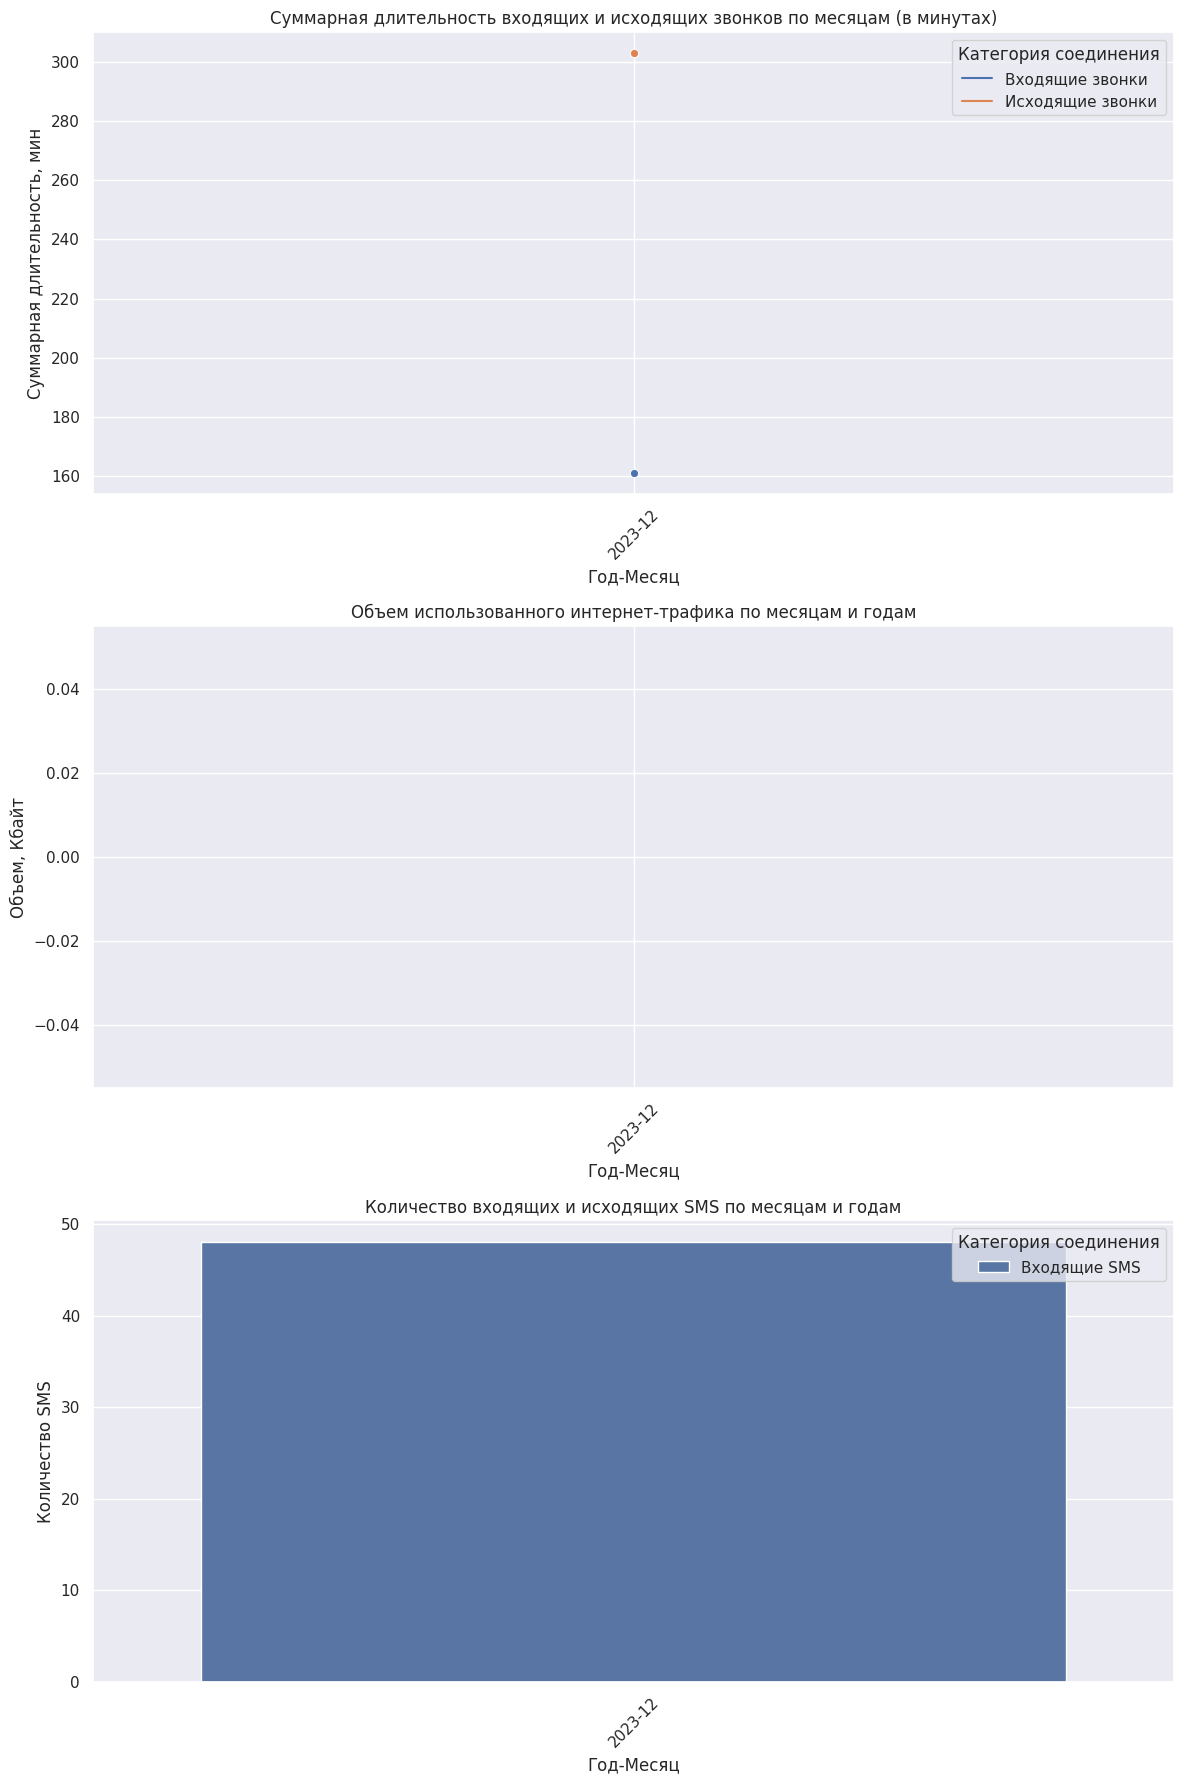

In [219]:
# Создание визуализаций
fig, ax = plt.subplots(3, 1, figsize=(12, 18))

# 1. Длительность входящих и исходящих звонков
sns.lineplot(data=personal_data_calls_summary, x='Год-Месяц', y='Длительность, мин.', hue='Категория соединения', marker='o', ax=ax[0])
ax[0].set_title('Суммарная длительность входящих и исходящих звонков по месяцам (в минутах)')
ax[0].set_ylabel('Суммарная длительность, мин')
ax[0].set_xlabel('Год-Месяц')
ax[0].tick_params(axis='x', rotation=45)
ax[0].legend(title='Категория соединения')


# 2. Объем использованного интернет-трафика по месяцам и годам
sns.lineplot(data=personal_data, x='Год-Месяц', y='Объем, Кбайт', estimator='sum', errorbar=None, ax=ax[1])
ax[1].set_title('Объем использованного интернет-трафика по месяцам и годам')
ax[1].set_ylabel('Объем, Кбайт')
ax[1].set_xlabel('Год-Месяц')
ax[1].tick_params(axis='x', rotation=45)

# 3. Количество входящих и исходящих SMS
sms_data = personal_data[personal_data['Тип'] == 'SMS']
sms_counts = sms_data.groupby(['Год-Месяц', 'Категория соединения']).size().reset_index(name='Количество SMS')
sns.barplot(x='Год-Месяц', y='Количество SMS', hue='Категория соединения', data=sms_counts, ax=ax[2])
ax[2].set_title('Количество входящих и исходящих SMS по месяцам и годам')
ax[2].set_ylabel('Количество SMS')
ax[2].set_xlabel('Год-Месяц')
ax[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

 ---
 
 <a id='an_complex'></a>
# Комплексный анализ поведения пользователей #
[Назад к содержанию](#contents)

Многоуровневый анализ поведения пользователей мобильного оператора, включая распределение по тарифам и статусам, анализ потребления услуг (минут и интернет-трафика), оценку экономической эффективности текущих тарифов по сравнению с потенциально оптимальными, и завершается кластеризацией пользователей для выявления общих паттернов поведения и предпочтений.

**Анализ распределения пользователей по тарифам и статусам**

Визуализация количества пользователей на различных тарифах помогает понять популярность каждого тарифа и может выявить тарифы с наибольшим и наименьшим числом абонентов.

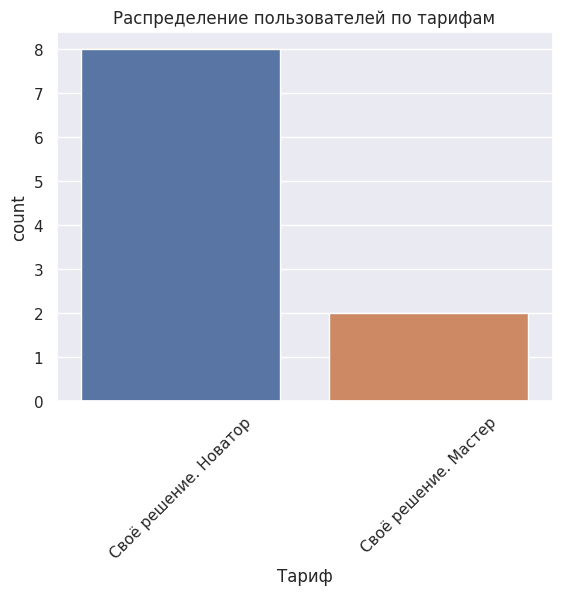

In [220]:
# Распределение пользователей по тарифам
sns.countplot(data=user_info, x='Тариф')
plt.title('Распределение пользователей по тарифам')
plt.xticks(rotation=45)
plt.show()

#### Анализ активных и неактивных пользователей. ####

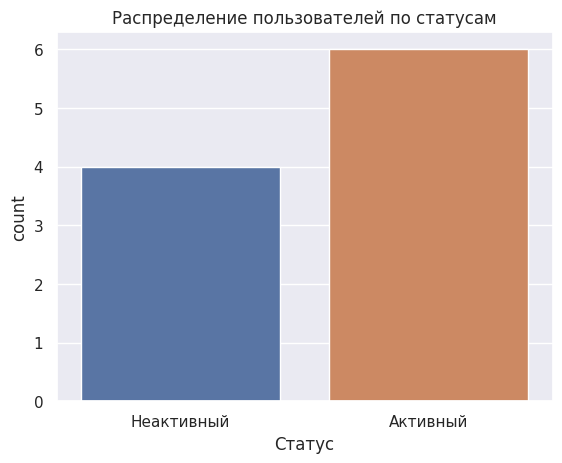

In [221]:
# Распределение пользователей по статусам
sns.countplot(data=user_info, x='Статус')
plt.title('Распределение пользователей по статусам')
plt.show()

#### Анализ потребления (минуты, трафик) ####
Сравнение среднемесячного потребления минут и интернет-трафика пользователями разных тарифов помогает оценить адекватность тарифных планов потребностям абонентов.

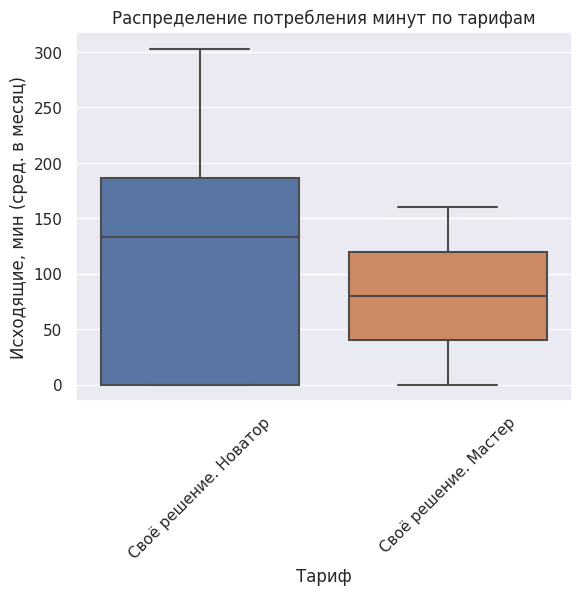

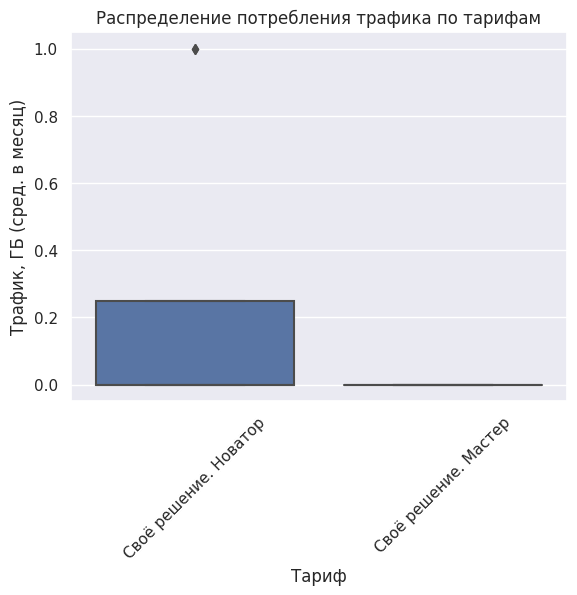

In [222]:
# Распределение потребления минут
sns.boxplot(data=user_info, x='Тариф', y='Исходящие, мин (сред. в месяц)')
plt.title('Распределение потребления минут по тарифам')
plt.xticks(rotation=45)
plt.show()

# Распределение потребления трафика
sns.boxplot(data=user_info, x='Тариф', y='Трафик, ГБ (сред. в месяц)')
plt.title('Распределение потребления трафика по тарифам')
plt.xticks(rotation=45)
plt.show()

#### Экономическая оценка тарифов: ###  
Расчет текущих расходов пользователей и сравнение с расходами по оптимальным тарифам позволяет выявить возможности для оптимизации и экономии средств абонентов.

In [223]:
# Добавление стоимости текущего тарифа к user_info
tariff_prices = {tariff: options[0]['price'] for tariff, options in tariffs_options.items()}

# Определение функции для получения текущей стоимости тарифа
def get_tariff_price(tariff_name):
    # Если тариф специальный для передачи данных
    if 'Передача данных' in tariff_name:
        return tariffs_options['Передача данных'][0]['price']
    
    # Для стандартных тарифов удаляем "Своё решение. " и возвращаем стоимость
    tariff_name_cleaned = tariff_name.replace("Своё решение. ", "")
    if tariff_name_cleaned in tariffs_options:
        return tariffs_options[tariff_name_cleaned][0]['price']
    return 0  # Возвращаем 0, если тариф не найден

# Применяем функцию к столбцу 'Тариф'
user_info['Текущая стоимость тарифа'] = user_info['Тариф'].apply(get_tariff_price)

# Расчет суммарных начислений для каждого пользователя из данных детализации
total_charges = data.groupby('Номер телефона')['Начислено'].sum().reset_index()
total_charges.rename(columns={'Начислено': 'Суммарные начисления'}, inplace=True)

# Объединение информации о пользователях с суммарными начислениями
user_info = user_info.merge(total_charges, on='Номер телефона', how='left')

# Расчет текущих расходов как суммы абонентской платы и суммарных начислений
user_info['Текущие расходы'] = user_info['Текущая стоимость тарифа'] + user_info['Суммарные начисления'].fillna(0)

# Добавление стоимости оптимального тарифа из предыдущего расчета
# Предположим, что стоимость оптимального тарифа уже добавлена в user_info как 'Стоимость тарифа'

# Расчет разницы в расходах
user_info['Разница в расходах'] = user_info['Текущие расходы'] - user_info['Стоимость тарифа']

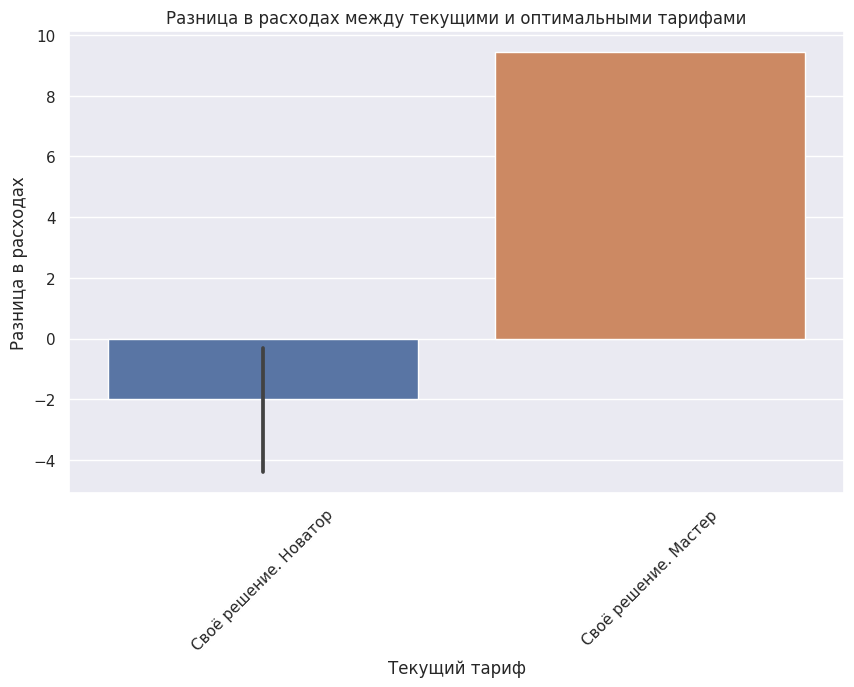

In [224]:
# Визуализация разницы в расходах
plt.figure(figsize=(10, 6))
sns.barplot(data=user_info, x='Тариф', y='Разница в расходах')
plt.title('Разница в расходах между текущими и оптимальными тарифами')
plt.xticks(rotation=45)
plt.ylabel('Разница в расходах')
plt.xlabel('Текущий тариф')
plt.show()

#### Кластеризация пользователей: ####  
Применение методов машинного обучения (K-means) для группировки пользователей по схожим паттернам использования услуг. Это помогает выделить типичные профили поведения для составления локального нормативного документа для описания принципов предоставления сотрудникам услуг мобильной связи.

/home/md/.local/lib/python3.10/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/md/.local/lib/python3.10/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/md/.local/lib/python3.10/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


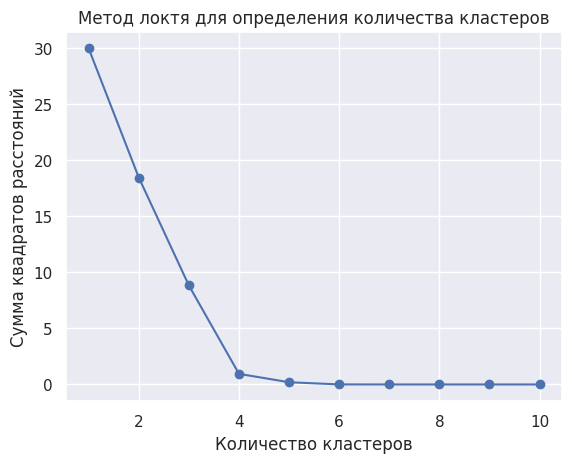

In [225]:
# Выбираем данные для кластеризации
X = user_info[['Исходящие, мин (сред. в месяц)', 'Трафик, ГБ (сред. в месяц)', 'Суммарные начисления']].fillna(0)

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
for n_clusters in range(1, 11):
    # Явное указание n_init=10 для предотвращения предупреждений
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Метод локтя для определения количества кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.show()

График метода локтя показывает изменение суммы квадратов расстояний между точками и центрами их кластеров при увеличении числа кластеров. Чтобы выбрать оптимальное количество кластеров, необходимо найти точку, в которой уменьшение суммы квадратов расстояний начинает замедляться, и эта точка больше не приносит значительного улучшения. Это часто выглядит как "локоть" на графике.

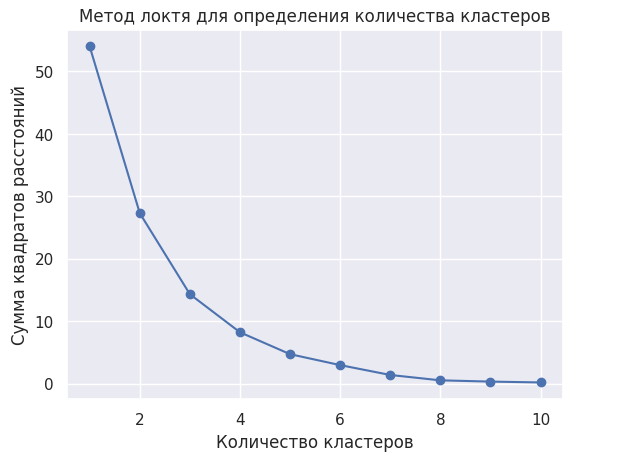

На представленном графике мы видим, что сумма квадратов расстояний резко уменьшается, когда количество кластеров увеличивается с 1 до 2, и продолжает уменьшаться уже менее интенсивно при увеличении количества кластеров до 3. После этого изменения становятся ещё менее значительными. Таким образом, "локоть", или точка изгиба, находится где-то между 2 и 3 кластерами.

На основании этого графика можно предложить, что оптимальное количество кластеров для данного набора данных лежит в диапазоне от 2 до 3. Выбор между этими значениями может зависеть от дополнительных соображений, таких как интерпретируемость кластеров и специфика задачи. Если 3 кластера предоставляют более полезное и информативное разделение данных, и эти кластеры могут быть четко интерпретированы и использованы в бизнес-процессах, тогда предпочтение следует отдать трём кластерам. Если же 2 кластера уже достаточно для выполнения аналитических задач, то можно остановиться на этом количестве, чтобы избежать излишней сложности.

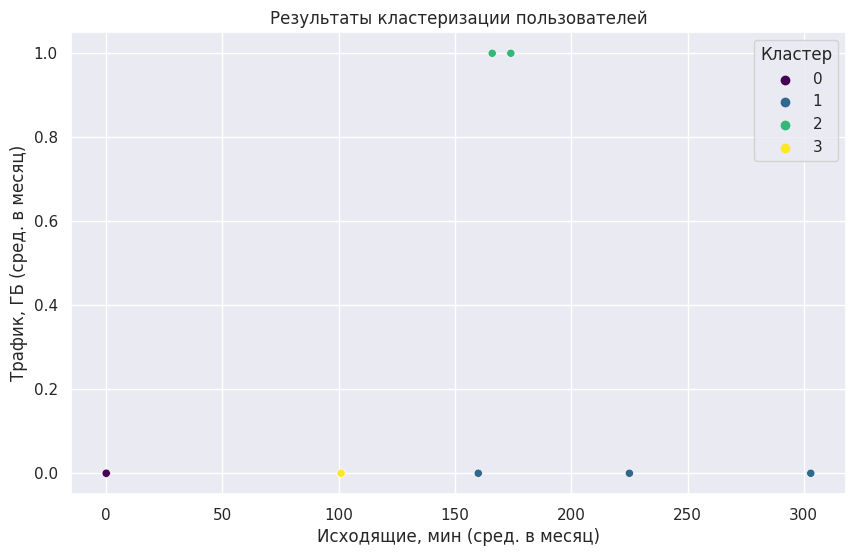

In [226]:
# Применяем K-means с выбранным количеством кластеров
optimal_clusters = 4  # Примерное оптимальное количество кластеров
kmeans = KMeans(n_clusters=optimal_clusters, n_init=10, random_state=42)  # Явно указываем n_init=10
user_info['Кластер'] = kmeans.fit_predict(X_scaled)

# Визуализация результатов кластеризации
plt.figure(figsize=(10, 6))
sns.scatterplot(data=user_info, x='Исходящие, мин (сред. в месяц)', y='Трафик, ГБ (сред. в месяц)', hue='Кластер', palette='viridis')
plt.title('Результаты кластеризации пользователей')
plt.show()

#### Анализ кластеров: ####   
Оценка средних значений ключевых показателей (использование минут, трафика, расходы) в каждом кластере, определение размеров кластеров и наиболее подходящих тарифов для них. Этот анализ предоставляет глубокое понимание разнообразия потребностей пользователей и может служить основой для индивидуализированных предложений.

In [227]:
# Анализ средних значений признаков по кластерам
cluster_means = user_info.groupby('Кластер')[['Исходящие, мин (сред. в месяц)', 'Трафик, ГБ (сред. в месяц)', 'Суммарные начисления']].mean()

# Добавление информации о количестве абонентов в каждом кластере
cluster_sizes = user_info.groupby('Кластер').size().reset_index(name='Количество абонентов')

# Определение наиболее часто встречающегося оптимального тарифа в каждом кластере
cluster_optimal_tariffs = user_info.groupby('Кластер')['Оптимальный тариф'].agg(lambda x: x.mode()[0]).reset_index(name='Оптимальный тариф для кластера')

# Соединение данных о средних значениях и количестве абонентов
cluster_analysis = cluster_means.merge(cluster_sizes, on='Кластер')

# Добавление информации об оптимальном тарифе
cluster_analysis = cluster_analysis.merge(cluster_optimal_tariffs, on='Кластер')

# Вывод результата
cluster_analysis

,Кластер,"Исходящие, мин (сред. в месяц)","Трафик, ГБ (сред. в месяц)",Суммарные начисления,Количество абонентов,Оптимальный тариф для кластера
0,0,0.000000,0.0,NaN,4,Новатор
1,1,229.333333,0.0,0.00,3,Новатор
2,2,170.000000,1.0,0.00,2,Новатор
3,3,101.000000,0.0,0.06,1,Новатор
